In [1]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astroquery.svo_fps import SvoFps
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def filter_selection_mask(cat):
    filters_with_detections = ['f480m','f410m','f405n', 'f360m']
    #filters_without_detections = ['f150w', 'f182m', 'f187n', 'f210m', 'f212n',]
    # 300, 360, 466 are optional
    mask_with = np.logical_and.reduce([~np.isnan(cat[f'mag_ab_{band}']) for band in filters_with_detections])
    #mask_without = np.logical_and.reduce([np.isnan(cat[f'mag_ab_{band}']) for band in filters_without_detections])
    mask = mask_with
    #mask = np.logical_and(maks_with, mask_without)

    return mask

In [3]:
cat_fn = '/orange/adamginsburg/jwst/sgrb2/NB/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits'
cat = Table.read(cat_fn)

In [4]:
masks = []
for colname in cat.colnames:
    if colname.startswith('emag'):
        col = cat[colname]
        # Condition is True if value < 0.1 or masked
        cond = (col < 0.1) | col.mask  
        masks.append(cond)

emag_mask = np.all(masks, axis=0)
cat = cat[emag_mask]
len(cat)

961982

In [5]:
masks = []
for colname in cat.colnames:
    if colname.startswith('spread'):
        col = cat[colname]
        # Condition is True if value > 0.7 or masked
        cond = (col < 0.25) | col.mask  
        masks.append(cond)
spread_mask = np.all(masks, axis=0)
cat = cat[spread_mask]
len(cat)

961856

In [6]:
masks = []
for colname in cat.colnames:
    if colname.startswith('fracflux'):
        col = cat[colname]
        # Condition is True if value > 0.7 or masked
        cond = (col > 0.8) | col.mask  
        masks.append(cond)
fracflux_mask = np.all(masks, axis=0)
cat = cat[fracflux_mask]
len(cat)

84490

In [7]:
cat

skycoord_ref,skycoord_ref_filtername,sep_f480m,id_f480m,skycoord_f480m,x_f480m,y_f480m,flux_f480m,passno_f480m,dx_f480m,dy_f480m,dflux_f480m,qf_f480m,rchi2_f480m,fracflux_f480m,fluxlbs_f480m,dfluxlbs_f480m,fwhm_f480m,spread_model_f480m,dspread_model_f480m,fluxiso_f480m,xiso_f480m,yiso_f480m,flags_f480m,sky_f480m,mask_f480m,dra_f480m,ddec_f480m,flux_jy_f480m,eflux_jy_f480m,mag_ab_f480m,emag_ab_f480m,near_saturated_f480m_f480m,replaced_saturated_f480m,sep_f466n,id_f466n,skycoord_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,flags_f466n,sky_f466n,mask_f466n,dra_f466n,ddec_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f410m,id_f410m,skycoord_f410m,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,flags_f410m,sky_f410m,mask_f410m,dra_f410m,ddec_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f405n,id_f405n,skycoord_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,flags_f405n,sky_f405n,mask_f405n,dra_f405n,ddec_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f360m,id_f360m,skycoord_f360m,x_f360m,y_f360m,flux_f360m,passno_f360m,dx_f360m,dy_f360m,dflux_f360m,qf_f360m,rchi2_f360m,fracflux_f360m,fluxlbs_f360m,dfluxlbs_f360m,fwhm_f360m,spread_model_f360m,dspread_model_f360m,fluxiso_f360m,xiso_f360m,yiso_f360m,flags_f360m,sky_f360m,mask_f360m,dra_f360m,ddec_f360m,flux_jy_f360m,eflux_jy_f360m,mag_ab_f360m,emag_ab_f360m,near_saturated_f360m_f360m,replaced_saturated_f360m,sep_f300m,id_f300m,skycoord_f300m,x_f300m,y_f300m,flux_f300m,passno_f300m,dx_f300m,dy_f300m,dflux_f300m,qf_f300m,rchi2_f300m,fracflux_f300m,fluxlbs_f300m,dfluxlbs_f300m,fwhm_f300m,spread_model_f300m,dspread_model_f300m,fluxiso_f300m,xiso_f300m,yiso_f300m,flags_f300m,sky_f300m,mask_f300m,dra_f300m,ddec_f300m,flux_jy_f300m,eflux_jy_f300m,mag_ab_f300m,emag_ab_f300m,near_saturated_f300m_f300m,replaced_saturated_f300m,sep_f212n,id_f212n,skycoord_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,flags_f212n,sky_f212n,mask_f212n,dra_f212n,ddec_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f210m,id_f210m,skycoord_f210m,x_f210m,y_f210m,flux_f210m,passno_f210m,dx_f210m,dy_f210m,dflux_f210m,qf_f210m,rchi2_f210m,fracflux_f210m,fluxlbs_f210m,dfluxlbs_f210m,fwhm_f210m,spread_model_f210m,dspread_model_f210m,fluxiso_f210m,xiso_f210m,yiso_f210m,flags_f210m,sky_f210m,mask_f210m,dra_f210m,ddec_f210m,flux_jy_f210m,eflux_jy_f210m,mag_ab_f210m,emag_ab_f210m,near_saturated_f210m_f210m,replaced_saturated_f210m,sep_f187n,id_f187n,skycoord_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,flags_f187n,sky_f187n,mask_f187n,dra_f187n,ddec_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_mod

In [8]:
image_filenames_pipe ={
    "f150w": "/orange/adamginsburg/jwst/sgrb2/NB/F150W/pipeline/jw05365-o001_t001_nircam_clear-f150w-merged_i2d.fits",
    "f182m": "/orange/adamginsburg/jwst/sgrb2/NB/F182M/pipeline/jw05365-o001_t001_nircam_clear-f182m-merged_i2d.fits", 
    "f187n": "/orange/adamginsburg/jwst/sgrb2/NB/F187N/pipeline/jw05365-o001_t001_nircam_clear-f187n-merged_i2d.fits", 
    "f210m": "/orange/adamginsburg/jwst/sgrb2/NB/F210M/pipeline/jw05365-o001_t001_nircam_clear-f210m-merged_i2d.fits", 
    "f212n": "/orange/adamginsburg/jwst/sgrb2/NB/F212N/pipeline/jw05365-o001_t001_nircam_clear-f212n-merged_i2d.fits", 
    "f300m": "/orange/adamginsburg/jwst/sgrb2/NB/F300M/pipeline/jw05365-o001_t001_nircam_clear-f300m-merged_i2d.fits",
    "f360m": "/orange/adamginsburg/jwst/sgrb2/NB/F360M/pipeline/jw05365-o001_t001_nircam_clear-f360m-merged_i2d.fits", 
    "f405n": "/orange/adamginsburg/jwst/sgrb2/NB/F405N/pipeline/jw05365-o001_t001_nircam_clear-f405n-merged_i2d.fits",
    "f410m": "/orange/adamginsburg/jwst/sgrb2/NB/F410M/pipeline/jw05365-o001_t001_nircam_clear-f410m-merged_i2d.fits", 
    "f466n": "/orange/adamginsburg/jwst/sgrb2/NB/F466N/pipeline/jw05365-o001_t001_nircam_clear-f466n-merged_i2d.fits", # weird, the filename is different from what is downloaded with the STScI pipeline...
    "f480m": "/orange/adamginsburg/jwst/sgrb2/NB/F480M/pipeline/jw05365-o001_t001_nircam_clear-f480m-merged_i2d.fits", 
    "f410m-f405n": "/orange/adamginsburg/jwst/sgrb2/NB/filter_subtractions/f405n_minus_f410m.fits",
    "f405n-f410m": "/orange/adamginsburg/jwst/sgrb2/NB/filter_subtractions/f405n_minus_f410m.fits",
    "f770w": "/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_images_try2/jw05365-o002_t002_miri_f770w_i2d.fits",
    "f1280w": "/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_images_try2/jw05365-o002_t002_miri_f1280w_i2d.fits",
    'f2550W': "/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_images_try2/jw05365-o002_t002_miri_f2550w_i2d.fits",
}

In [9]:
def get_line_excess(catalog, narrow, wide):
    ww_narrow = WCS(fits.getheader(image_filenames_pipe[narrow], ext=('SCI', 1)))
    ww_wide = WCS(fits.getheader(image_filenames_pipe[wide], ext=('SCI', 1)))
    data_narrow = (catalog['flux_' + narrow] * u.MJy/u.sr * ww_narrow.proj_plane_pixel_area()).to(u.Jy)
    data_wide = (catalog['flux_' + wide] * u.MJy/u.sr * ww_wide.proj_plane_pixel_area()).to(u.Jy)

    wavelength_table_narrow = SvoFps.get_transmission_data(f'JWST/NIRCAM.{narrow}')
    wavelength_table_wide = SvoFps.get_transmission_data(f'JWST/NIRCAM.{wide}')

    waves_wide = wavelength_table_wide['Wavelength']
    trans_narrow = np.interp(waves_wide, wavelength_table_narrow['Wavelength'], wavelength_table_narrow['Transmission'])
    trans_wide = wavelength_table_wide['Transmission']


    fractional_bandwidth = ( (trans_wide/trans_wide.max()) * (trans_narrow/trans_narrow.max()) ).sum() / (trans_wide/trans_wide.max()).sum()
    print(f'Fractional bandwidth: {fractional_bandwidth}')
    if fractional_bandwidth == 1:
        print("The filters either have no overlap or are identical. Exiting")
        return


    wide_minus_narrow = (data_wide - data_narrow * fractional_bandwidth) / (1-fractional_bandwidth)
    #return wide_minus_narrow

    narrow_minus_wide = data_narrow - wide_minus_narrow
    #narrow_minus_wide = (data_narrow - data_wide * fractional_bandwidth) / (1-fractional_bandwidth)
    return np.array(narrow_minus_wide)  # Ensure writable copy

paa_excess = get_line_excess(cat, 'f187n', 'f182m')
bra_excess = get_line_excess(cat, 'f405n', 'f410m')

Fractional bandwidth: 0.09655212419159323
Fractional bandwidth: 0.1027882360899125


Set DATE-AVG to '2024-09-07T11:59:42.775' from MJD-AVG.
Set DATE-END to '2024-09-07T13:59:11.263' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.939008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1300551270.825 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T16:21:01.359' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T10:44:37.117' from MJD-AVG.
Set DATE-END to '2024-09-07T12:26:08.056' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.939008 from OBSGEO-[XYZ].
Set OBSGEO-H to 1300551270.825 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-09-07T16:21:01.379' from MJD-AVG.
Set DATE-END to '2024-09-07T17:05:17.716' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.647443 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298271102.952 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(0.5, 0, 'Bra excess, Jy?')

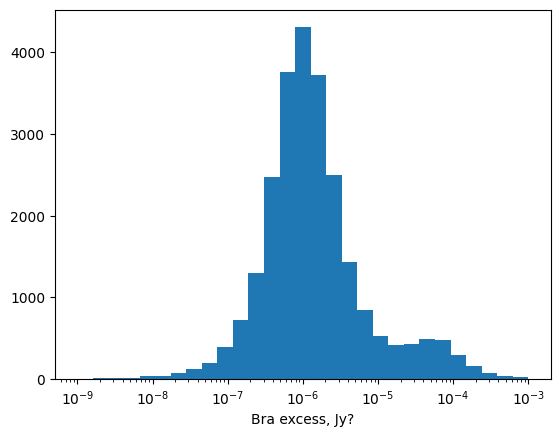

In [10]:
plt.hist(bra_excess, bins=np.logspace(-9, -3, 30))
plt.xscale('log')
plt.xlabel('Bra excess, Jy?')

[]

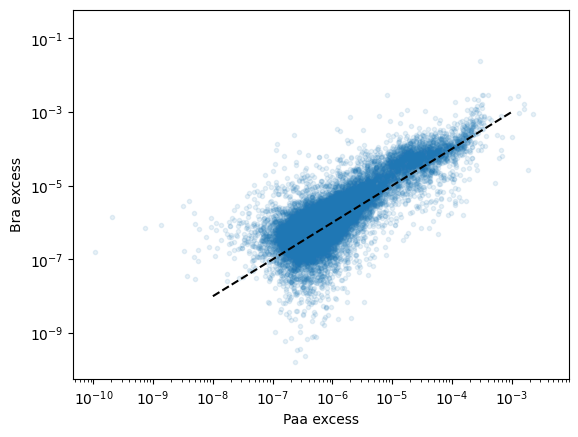

In [11]:
plt.scatter(paa_excess, bra_excess, marker='.', alpha = 0.1)
plt.xlabel('Paa excess')
plt.ylabel('Bra excess')
plt.plot([1e-8, 1e-3], [1e-8, 1e-3], 'k--')  # Add a reference line for equal excesses
plt.loglog()


/scratch/local/25862348/ipykernel_1098528/3398600629.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hexbin(np.log10(paa_excess), np.log10(bra_excess), norm=LogNorm())


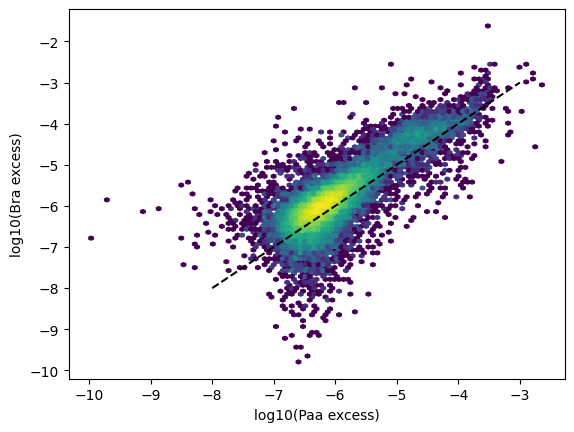

In [12]:
plt.hexbin(np.log10(paa_excess), np.log10(bra_excess), norm=LogNorm())
plt.xlabel('log10(Paa excess)')
plt.ylabel('log10(Bra excess)')
plt.plot([np.log10(1e-8), np.log10(1e-3)], [np.log10(1e-8), np.log10(1e-3)], 'k--')  # Add a reference line for equal excesses

In [13]:
paa_bra_ratio_BW_scaled = (paa_excess * 0.024) / (bra_excess * 0.046)

In [14]:
emissivity_ratio = 4.24

In [15]:
from dust_extinction.parameter_averages import CCM89, G23
from dust_extinction.averages import F11_MWGC, CT06_MWGC

In [16]:
#ext = G23(Rv=3.1)
ext = CT06_MWGC() 
R_intrinsic = emissivity_ratio

In [17]:
wavelengths = np.array([1.87, 4.05])* u.micron
A_lambda_over_Av = ext(wavelengths)
k = A_lambda_over_Av[0] - A_lambda_over_Av[1]

In [18]:
A_V = 2.5 * np.log10(R_intrinsic / paa_bra_ratio_BW_scaled) / k

/scratch/local/25862348/ipykernel_1098528/1980414983.py:1: RuntimeWarning: invalid value encountered in log10
  A_V = 2.5 * np.log10(R_intrinsic / paa_bra_ratio_BW_scaled) / k


Text(0.5, 0, 'A_V (catalog based)')

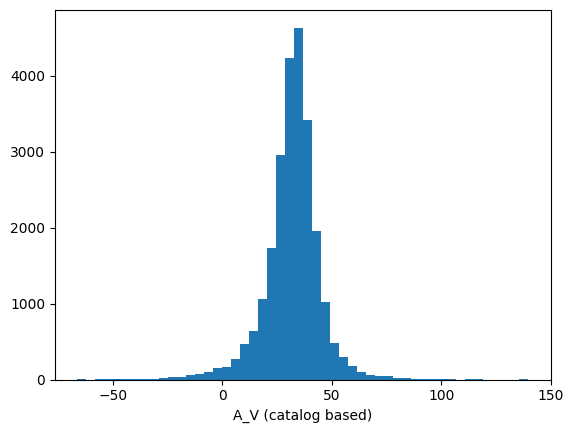

In [19]:
plt.hist(A_V, bins=50)
plt.xlabel('A_V (catalog based)')

In [49]:
def cardelli_law(wavelength, RV=3):
    wavenumber = (wavelength.to(u.um**-1, u.spectral())).value
    a = 0.574 * wavenumber**1.61
    b = -0.527 * wavenumber**1.61
    A_lambda = a + b / RV
    return A_lambda

In [39]:
from astropy import units as u
from astropy import constants
from pyspeckit.spectrum.models import hydrogen
#from hii_sensitivity import ha_to_hb_1e4, paa_to_hb_1e4, bra_to_hgamma_1e4, pab_to_hgamma_1e4, hg_to_hb_1e4, wl_paa
from astroquery.svo_fps import SvoFps

wl_bra = hydrogen.wavelength['bracketta']*u.um
twomass = SvoFps.get_filter_list('2MASS')
wl_Ks = twomass[twomass['filterID'].astype(str)=='2MASS/2MASS.Ks']['WavelengthCen'][0] * u.AA
def lacc(mdot, rstar=u.R_sun, mstar=u.M_sun):
    # Alcala+ 2017 eqn 1
    # 1.25 comes from assuming r_inner disk = 5 r_star
    return (mdot / 1.25 * constants.G * mstar / rstar).to(u.L_sun)
def log_pab(lacc):
    # from table B1 of Alcala+2017:
    # log L_acc = 1.06 log L_pab + 2.76
    # so
    # log L_pab = (log L_acc - 2.76) / 1.06
    return 1/1.06 * np.log10(lacc/u.L_sun) - 2.76/1.06

def log_paa(lacc):
    # pab * (paa / hb) * (hb / hg) *  (hg / pab)
    return log_pab(lacc) + np.log10(paa_to_hb_1e4 / hg_to_hb_1e4 / pab_to_hgamma_1e4)

def log_bra(lacc):
    # brackett alpha prediction from PaB (could use BrG too...)
    return log_pab(lacc) + np.log10(bra_to_hgamma_1e4 / pab_to_hgamma_1e4)

def L_paa(lacc):
    return 10**log_paa(lacc) * u.L_sun

def L_bra(lacc):
    return 10**log_bra(lacc) * u.L_sun

def S_paa(lacc, distance=5.4*u.kpc, A_K=0):
    A_paa = (cardelli_law(wl_paa) / cardelli_law(wl_Ks)) * A_K
    attenuation = 10**(-A_paa / 2.5)
    return (L_paa(lacc) / (4*np.pi*distance**2)).to(u.erg/u.s/u.cm**2) * attenuation

def S_bra(lacc, distance=5.4*u.kpc, A_K=0):
    A_bra = (cardelli_law(wl_bra) / cardelli_law(wl_Ks)) * A_K
    attenuation = 10**(-A_bra / 2.5)
    return (L_bra(lacc) / (4*np.pi*distance**2)).to(u.erg/u.s/u.cm**2) * attenuation

#lacc_vals = lacc(mdot)
#spaa = S_paa(lacc_vals, distance=5.4*u.kpc)
#sbra = S_bra(lacc_vals, distance=5.4*u.kpc)

#get the inverse
def macc(Ldot, rstar=u.R_sun, mstar=u.M_sun):
    # Invert the lacc equation to get macc
    return (Ldot * 1.25 * rstar / (constants.G * mstar)).to(u.M_sun/u.yr)
def Lbra_to_lacc(L_bra):
    try:
        loglacc = 1.06*(np.log10(L_bra/u.L_sun) +2.76/1.06 - np.log10(paa_to_hb_1e4 / hg_to_hb_1e4 / pab_to_hgamma_1e4))
    except Exception as e:
        loglacc = -99
    return 10**loglacc * u.L_sun
def Lpaa_to_lacc(L_paa):
    try:
        loglacc = 1.06*(np.log10(L_paa/u.L_sun) +2.76/1.06 - np.log10(bra_to_hgamma_1e4 / pab_to_hgamma_1e4))
    except Exception as e:
        loglacc = -99
    return 10**loglacc * u.L_sun

def S_paa_to_lacc(S_paa, distance=5.4*u.kpc, A_K=0):
    # Invert the S_paa equation to get lacc
    A_paa = (cardelli_law(wl_paa) / cardelli_law(wl_Ks)) * A_K
    attenuation = 10**(-A_paa / 2.5)
    L_paa = (S_paa * 4*np.pi*distance**2 / attenuation).to(u.L_sun)
    L_acc = Lbra_to_lacc(L_paa)
    return L_acc


def S_bra_to_lacc(S_bra, distance=5.4*u.kpc, A_K=0):
    # Invert the S_bra equation to get lacc
    A_bra = (cardelli_law(wl_bra) / cardelli_law(wl_Ks)) * A_K
    attenuation = 10**(-A_bra / 2.5)
    L_bra = (S_bra * 4*np.pi*distance**2 / attenuation).to(u.L_sun)
    L_acc = Lbra_to_lacc(L_bra)
    return L_acc

In [37]:
wl_bra

<Quantity 4.0523 um>

In [ ]:
# av_values = A_V

# wl_paa = hydrogen.wavelength['paschena']*u.um

# paa_excess_ergscm2 = paa_excess * 1e-23 * (3e18 / wl_paa.to(u.AA).value**2) * u.erg/u.s/u.cm**2 *236.69
# bra_excess_ergscm2 = bra_excess * 1e-23 * (3e18 / wl_bra.to(u.AA).value**2) * u.erg/u.s/u.cm**2 * 454.87 
# L_paa_values = S_paa_to_lacc(paa_excess_ergscm2, distance=8.4*u.kpc, A_K=0.1*av_values)
# L_bra_values = S_bra_to_lacc(bra_excess_ergscm2, distance=8.4*u.kpc, A_K=0.1*av_values)
# print(L_paa_values)
# macc_from_paa = macc(L_paa_values)
# macc_from_bra = macc(L_bra_values)

1e-99 solLum


invalid value encountered in log10


In [48]:
L_paa_values

<Quantity 1.e-99 solLum>

ValueError: 'c' argument has 84490 elements, which is inconsistent with 'x' and 'y' with size 1.

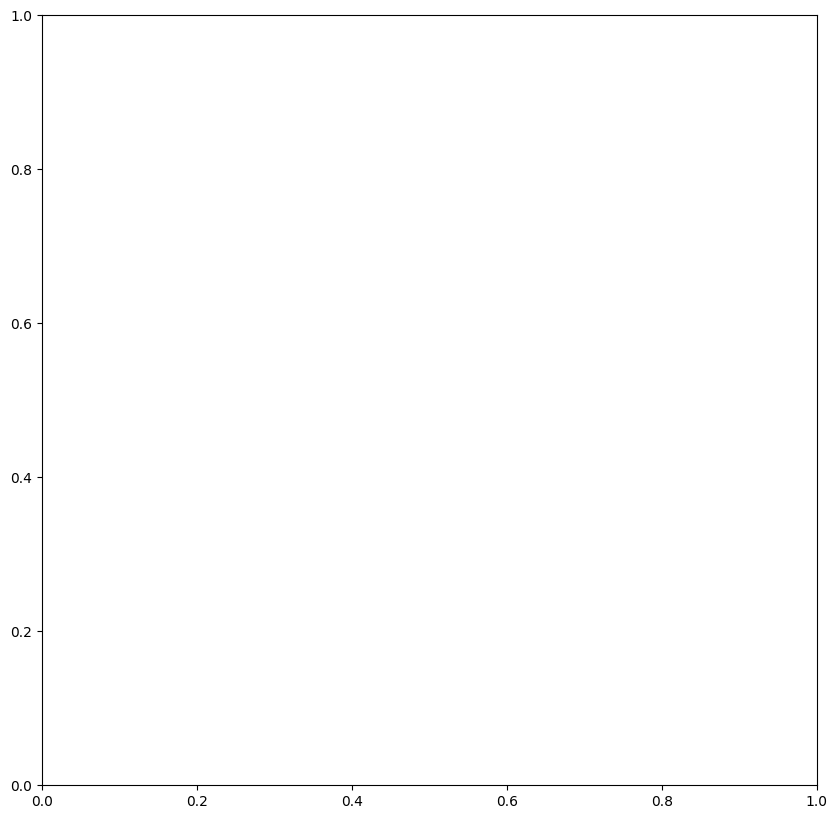

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(macc_from_paa.value, macc_from_bra.value, s=10, c=av_values, alpha=0.5, edgecolor='none')
ax.set_xlabel('Mass accretion rate from Pa alpha (M_sun/yr)')
ax.set_ylabel('Mass accretion rate from Br alpha (M_sun/yr)')
ax.set_title('Mass accretion rates from Pa alpha vs Br alpha')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([1e-15, 1e-7], [1e-15, 1e-7], color='r', linestyle='--')  # 1:1 line
plt.tight_layout()

In [54]:
def plot_CCD_density(cat, band1, band2, band3, band4, gridsize=50, ax=None, save = False, A_V = None, **kwargs, ):
    if ax is None:
        ax = plt.gca()

    mags1 = cat[f'mag_ab_{band1}']
    mags2 = cat[f'mag_ab_{band2}']
    mags3 = cat[f'mag_ab_{band3}']
    mags4 = cat[f'mag_ab_{band4}']

    color1 = mags1 - mags2
    color2 = mags3 - mags4

    hb = ax.scatter(color1, color2, c=bra_excess.value, cmap='viridis', norm=LogNorm(), **kwargs)

    
    fontsize = 14

    ax.set_xlabel(rf'[{band1.upper()}] $-$ [{band2.upper()}]', fontsize=fontsize)
    ax.set_ylabel(rf'[{band3.upper()}] $-$ [{band4.upper()}]', fontsize=fontsize)

    # determine appropriate limits:
    f = 6
    xlim = (np.mean(color1) - f * np.std(color1), np.mean(color1) + f * np.std(color1))
    ylim = (np.mean(color2) - f * np.std(color2), np.mean(color2) + f * np.std(color2))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    cbar = plt.colorbar(hb, ax=ax)#, label='Number of sources')
    cbar.set_label('Number of sources', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    cbar.ax.tick_params(labelsize=fontsize-2)
    
    if A_V is not None:
        A_lambda1 = extinction_coeffs.get(band1.lower(), 0)
        A_lambda2 = extinction_coeffs.get(band2.lower(), 0)
        A_lambda3 = extinction_coeffs.get(band3.lower(), 0)
        A_lambda4 = extinction_coeffs.get(band4.lower(), 0)

        dx = (A_lambda1 - A_lambda2) * A_V
        dy = (A_lambda3 - A_lambda4) * A_V
        
        x0 = xlim[0] + 0.2 * (xlim[1] - xlim[0])
        y0 = ylim[0] + 0.1 * (ylim[1] - ylim[0])

        x0 = 0

        ax.arrow(x0, y0 + 2.2, dx, dy, color='k', width=0.05,
            head_width=0.2, length_includes_head=True, label=rf'$A_V={A_V}$')

        ax.text(x0 -0.2, y0 + 3, rf'$A_V={A_V}$', color='k', fontsize= fontsize-2)

    if save:
        plt.savefig(f'/orange/adamginsburg/jwst/sgrb2/NB/catalogs/catalog_attempt_Jan2025/catalog_plotting/pngs/CCD_density_{band1}_{band2}_{band3}_{band4}.png', dpi=200)

    return ax

AttributeError: 'numpy.ndarray' object has no attribute 'value'

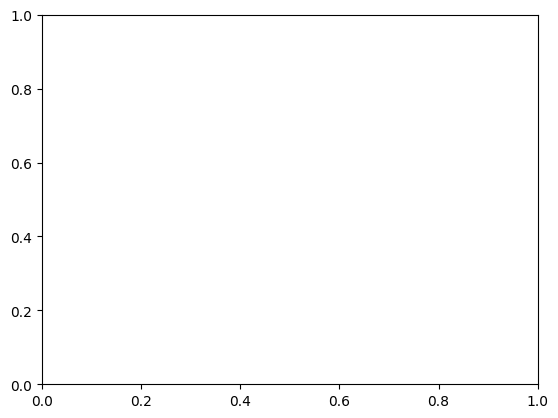

In [55]:
ax = plot_CCD_density(cat,'f182m','f212n', 'f212n', 'f410m', gridsize = 500, save = False)
#ax.set_xlim(-2,3)
#ax.set_ylim(-3,2)
#ax.set_xlim(0,3)
#ax.set_ylim(-2.5,1.5)